In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
# Lendo arquivo
arquivo = 'dados-2020-05-18.csv'
df = pd.read_csv(arquivo)

# Mudando nomes das colunas
df.columns = ['Pais', 'Codigo', 'Data', 'MortesPorMilhao']

In [3]:
# Alterando 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'], format='%b %d, %Y', errors='ignore')

# Criando coluna com a semana do ano, para fazer esse agrupamento
df['Semana'] = df['Data'].dt.week

# Forçando ordenação por país e data
df.sort_values(['Pais', 'Data'], inplace=True)

In [4]:
# Criando coluna NovoPais para facilitar próxima etapa
df['NovoPais'] = df['Pais'].ne(df['Pais'].shift())

# Criando coluna MortesPorDiaPorMilhao, para calcular estágio da pandemia
df['MortesPorDiaPorMilhao'] = df['MortesPorMilhao'] - df['MortesPorMilhao'].shift()

# Zerando mortes por dia no primeiro dia de cada país
df.loc[df.NovoPais == True, 'MortesPorDiaPorMilhao'] = 0.0

# Tira NovoPais depois que já foi usado
df.drop('NovoPais', axis=1, inplace=True)

In [5]:
df.head()

,Pais,Codigo,Data,MortesPorMilhao,Semana,MortesPorDiaPorMilhao
0,Afghanistan,AFG,2019-12-31,0.0,1,0.0
1,Afghanistan,AFG,2020-01-01,0.0,1,0.0
2,Afghanistan,AFG,2020-01-02,0.0,1,0.0
3,Afghanistan,AFG,2020-01-03,0.0,1,0.0
4,Afghanistan,AFG,2020-01-04,0.0,1,0.0


In [6]:
# df[df['Codigo'] == "BRA"]

In [7]:
# Pegando dados apenas da Semana 8 para frente
dados_semana8 = df.loc[(df.Semana >= 8) & (df.Semana < df.Semana.max())]

# Agrupando os dados por País e por Semana e fazendo a soma das colunas numéricas
agrupamento = dados_semana8.groupby(['Pais', 'Semana']).sum().reset_index()

# Vamos usar a coluna MortesPorDiaPorMilhao, então podemos deletar MortesPorMilhao
agrupamento.drop('MortesPorMilhao', axis=1, inplace=True)

# Mudando o nome da coluna (saindo PorDia e passando para PorSemana)
agrupamento.columns = ['Pais', 'Semana', 'MortesPorSemanaPorMilhao']

# Pegando o primeiro dia de cada semana para facilitar leitura
agrupamento["DiaSemana"] = agrupamento["Semana"].apply(
    lambda i: (datetime.datetime.strptime("01/01/2020", "%d/%m/%Y") + datetime.timedelta(i*7-9))
)

In [8]:
agrupamento.head()

,Pais,Semana,MortesPorSemanaPorMilhao,DiaSemana
0,Afghanistan,8,0.0,2020-02-17
1,Afghanistan,9,0.0,2020-02-24
2,Afghanistan,10,0.0,2020-03-02
3,Afghanistan,11,0.0,2020-03-09
4,Afghanistan,12,0.0,2020-03-16


In [9]:
# agrupamento.loc[agrupamento.Pais == "Brazil"]
# agrupamento.loc[agrupamento.Pais == "Germany"]

In [10]:
# agrupamento.loc[agrupamento.Pais == "Germany"].describe()
# agrupamento.loc[agrupamento.Pais == "Brazil"].describe()

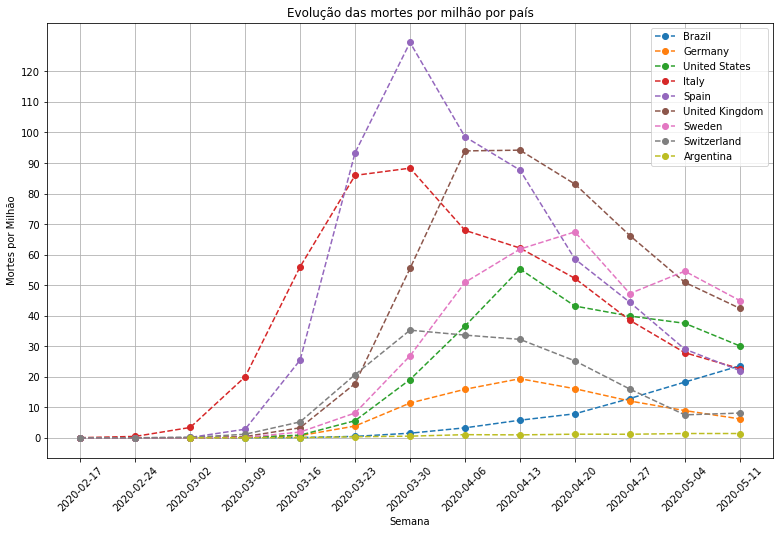

In [11]:
# Aumentando gráfico
plt.figure(figsize=(13,8))

# Selecionando alguns países
paises = ["Brazil", "Germany", "United States", "Italy", "Spain",
          "United Kingdom", "Sweden", "Switzerland", "Argentina"]

# Fazendo o plot DiaSemana X MortesPorSemanaPorMilhao para cada país
for i in range(len(paises)):
    pais = paises[i]
    dados = agrupamento.loc[agrupamento.Pais == pais]
    plt.plot(dados['DiaSemana'], dados['MortesPorSemanaPorMilhao'], 'o--', label=pais)

# Grid na vertical de 10 em 10
plt.yticks(range(0,130, 10))
# Grid na horizontal para todos os dias
plt.xticks(agrupamento["DiaSemana"].unique(), rotation=45)

plt.legend()
plt.title("Evolução das mortes por milhão por país")
plt.xlabel("Semana")
plt.ylabel("Mortes por Milhão")
plt.grid()